In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from pixell import enmap, utils
import scipy.signal as ss
import time
import scipy.interpolate as si
import os
import tqdm.notebook as tqdm

In [2]:
def get_cmb_power_spectra(fixed_cosmo=True, r=None):
    """
    Get CMB power spectra from CAMB.

    Parameters
    ----------
    fixed_cosmo : bool
        If False, all cosmo parameters are drawn from random distributions consistent with Planck 2018 I. results.
        If True, we just use the best fit values
    r : float
        Tensor-to-scalar ratio. If None, we draw a random value consistent with constraints from Planck 2018 I. results.
    """
    pars = camb.CAMBparams()

    # From Planck 2018 I. paper Table 7
    H0 = np.random.normal(67.36, 0.54) if not fixed_cosmo else 67.36
    ombh2 = np.random.normal(0.02237, 0.00015) if not fixed_cosmo else 0.02237
    omch2 = np.random.normal(0.12, 0.0012) if not fixed_cosmo else 0.12
    tau = np.random.normal(0.0544, 0.0073) if not fixed_cosmo else 0.0544
    logas = np.random.normal(3.044, 0.014) if not fixed_cosmo else 3.044
    As = np.exp(logas) / 1e10
    ns = np.random.normal(0.9649, 0.0042) if not fixed_cosmo else 0.9649

    # From Planck 2018 I. paper, see Sect. 5.3
    mnu = np.random.uniform(0.06, 0.1) if not fixed_cosmo else 0.8

    # Inspired from the upper limit of Planck 2018 I. paper
    logr = np.random.uniform(-3, -1.494850021680094)
    if r is None:
        r = 10**logr

    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=0, tau=tau)
    pars.InitPower.set_params(As=As, ns=ns, r=r)
    pars.set_for_lmax(4000, lens_potential_accuracy=0)
    pars.WantTensors = True
    results = camb.get_results(pars)
    Cl_TT, Cl_EE, Cl_BB, CL_TE = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)['total'].T
    
    return Cl_TT, Cl_EE, Cl_BB, CL_TE

def patch_shape_and_wcs(Npix, res):
    ndegree_patch = res * Npix / 60
    print(f"Size of the patch in degrees: {ndegree_patch:.2f}")
    box = np.array([[-1, 1], [1, -1]]) * utils.degree * ndegree_patch / 2
    shape, wcs = enmap.geometry(pos=box, res=res*utils.arcmin, proj='car')
    return shape, wcs

In [3]:
pars = camb.CAMBparams()

fixed_cosmo = True
zero_r = False

# From Planck 2018 I. paper Table 7
H0 = np.random.uniform(50, 90) if not fixed_cosmo else 70
ombh2 = np.random.uniform(7.5e-3,56.7e-3) if not fixed_cosmo else (7.5e-3+56.7e-3)/2
omch2 = np.random.normal(0.12, 0.0012) if not fixed_cosmo else 0.12
tau = np.random.normal(0.0544, 0.0073) if not fixed_cosmo else 0.0544
logas = np.random.normal(3.044, 0.014) if not fixed_cosmo else 3.044
As = np.exp(logas) / 1e10
ns = np.random.normal(0.9649, 0.0042) if not fixed_cosmo else 0.9649

# From Planck 2018 I. paper, see Sect. 5.3
mnu = np.random.uniform(0.06, 0.1) if not fixed_cosmo else 0.8

# Inspired from the upper limit of Planck 2018 I. paper
logr = np.random.uniform(-3, -1.494850021680094)
if not zero_r:
    r = 10**logr
else:
    r = 0

pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=0, tau=tau)
pars.InitPower.set_params(As=As, ns=ns, r=r)
pars.set_for_lmax(4000, lens_potential_accuracy=0)
pars.WantTensors = True

results = camb.get_results(pars)
cl_TT, cl_EE, cl_BB, cl_TE = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)['total'].T


dl_TT1 = cl_TT * (np.arange(len(cl_TT)) * (np.arange(len(cl_TT)) + 1)) / (2 * np.pi)
dl_EE1 = cl_EE * (np.arange(len(cl_EE)) * (np.arange(len(cl_EE)) + 1)) / (2 * np.pi)
dl_BB1 = cl_BB * (np.arange(len(cl_BB)) * (np.arange(len(cl_BB)) + 1)) / (2 * np.pi)
dl_TE1 = cl_TE * (np.arange(len(cl_TE)) * (np.arange(len(cl_TE)) + 1)) / (2 * np.pi)

In [4]:
comp = np.zeros((3, 3, cl_TT.shape[-1]))
comp[0,0] = cl_TT
comp[1,1] = cl_EE
comp[0,1] = cl_TE
comp[1,0] = cl_TE
comp[2,2] = cl_BB

In [5]:
Npix = 256    # Number of pixels
res = 8       # Size of a pixel, in arcminutes

shape_patch, wcs_patch = patch_shape_and_wcs(Npix, res)
cmb_maps = enmap.rand_map([3, shape_patch[0], shape_patch[1]], wcs_patch, comp)
#print(cmb_maps.shape)
I, Q, U = cmb_maps[0], cmb_maps[1], cmb_maps[2]
shape = [3, shape_patch[0], shape_patch[1]]

Size of the patch in degrees: 34.13


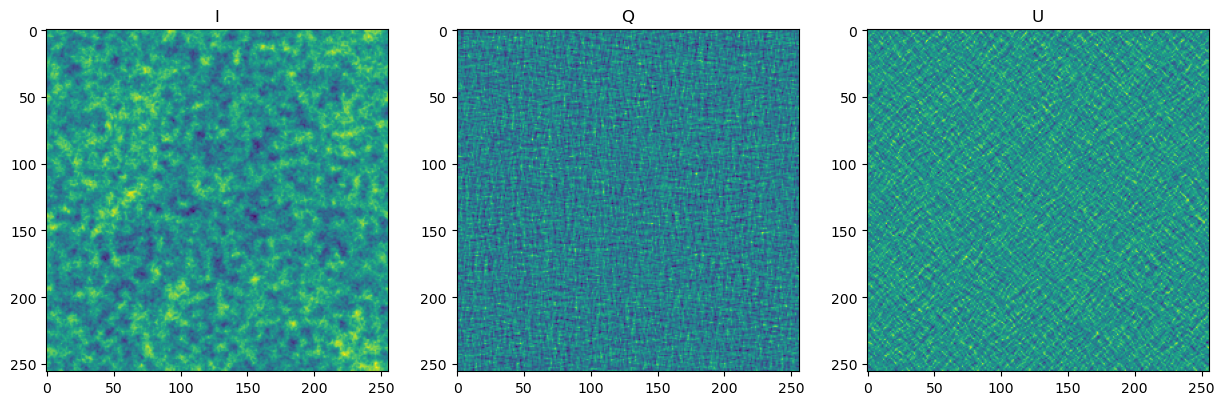

In [6]:
## Plot I, Q and U maps of the CMB
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cmb_maps[0])
ax[1].imshow(cmb_maps[1])
ax[2].imshow(cmb_maps[2])
ax[0].set_title('I')
ax[1].set_title('Q')
ax[2].set_title('U')
plt.show()

In [7]:
ps_maps = enmap.spec2flat(shape, wcs_patch, enmap.massage_spectrum(comp, shape), 1, mode='constant')

ps_TT = ps_maps[0, 0]
ps_EE = ps_maps[1, 1]
ps_TE = ps_maps[0, 1]
ps_BB = ps_maps[2, 2]

In [8]:
## Time how long it takes to run the previous cell

# Burnin
burnin = 10
for i in range(burnin):
    ps_maps = enmap.spec2flat(shape, wcs_patch, enmap.massage_spectrum(comp, shape), 1, mode='constant')
    ps_TT = ps_maps[0, 0]
    ps_EE = ps_maps[1, 1]
    ps_TE = ps_maps[0, 1]
    ps_BB = ps_maps[2, 2]

begining = time.time()
massaged = enmap.massage_spectrum(comp, shape)
for i in range(100):
    ps_maps = enmap.spec2flat(shape, wcs_patch, massaged , 1, mode='constant')

end = time.time()
ps_TT = ps_maps[0, 0]
ps_EE = ps_maps[1, 1]
ps_TE = ps_maps[0, 1]
ps_BB = ps_maps[2, 2]
print('Time to generate a cmb isotropic power spectrum: ', (end-begining)/100, 's')

Time to generate a cmb isotropic power spectrum:  0.01368349313735962 s


In [9]:
diag =(np.fft.fftshift(np.log(ps_TT).diagonal()))

In [10]:
idx_i = np.arange(0,256).reshape(-1,1)
idx_j = np.arange(0,256).reshape(1,-1)
dist = np.sqrt((idx_i-12)**2 + (idx_j-128)**2)

In [11]:
wn = (256*np.fft.fftfreq(256, d=1.0)).reshape((256,) + (1,) * (2 - 1))
wn_iso = np.zeros((256,256))
for i in range(2):
    wn_iso += np.moveaxis(wn, 0, i) ** 2
wn_iso = np.sqrt(wn_iso)

In [12]:
np.fft.fftshift(wn_iso)[129,128]

1.0

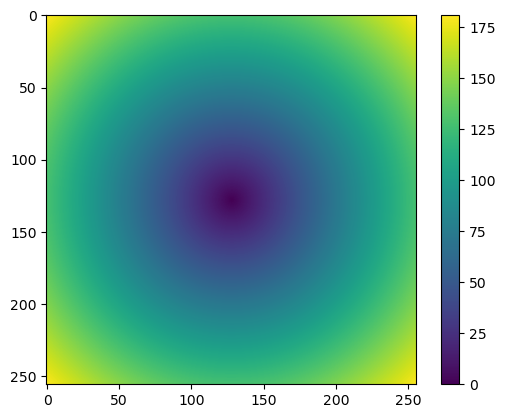

In [13]:
plt.imshow(np.fft.fftshift(wn_iso))
plt.colorbar()

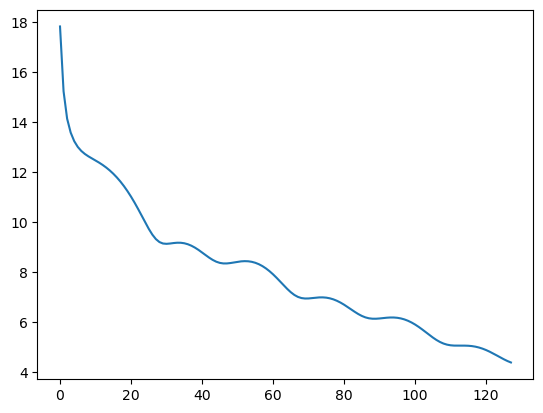

In [14]:
up_diag = diag[128:]
indices = np.fft.fftshift(wn_iso).diagonal()[128:]
plt.plot(up_diag)

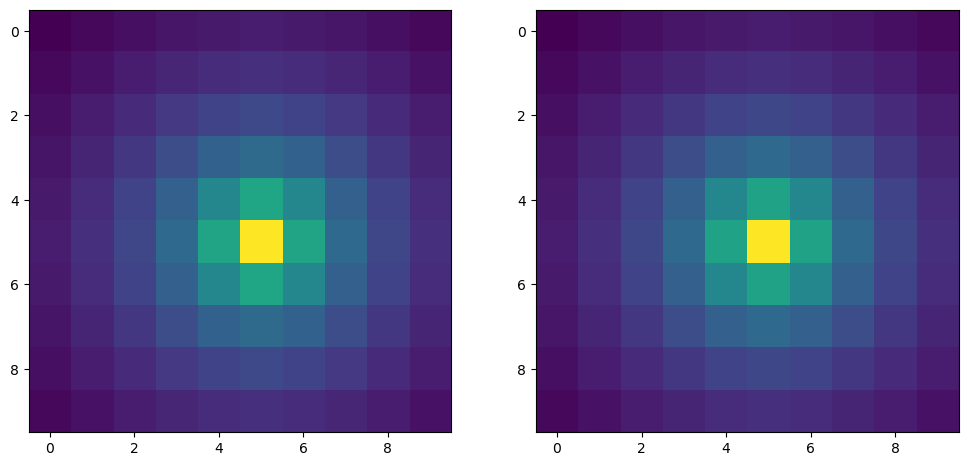

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(np.fft.fftshift(np.log(ps_TT))[123:133, 123:133])
ax[1].imshow((si.CubicSpline(indices, up_diag)(np.fft.fftshift(wn_iso)))[123:133, 123:133])

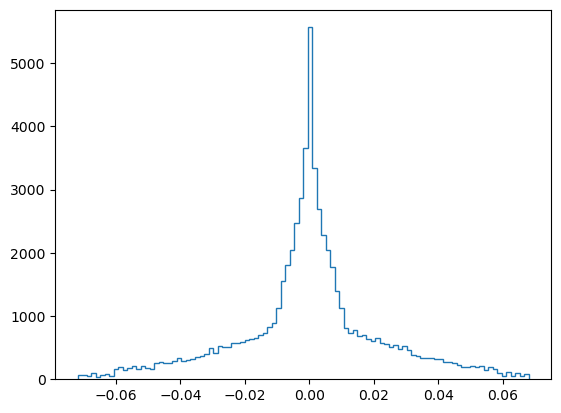

In [16]:
plt.hist(((ps_TT-np.exp(si.make_interp_spline(indices, up_diag)(wn_iso)))/ps_TT).flatten(), bins=100, histtype='step', label='TT')
plt.show()

In [17]:
ps_hat = np.fft.fftshift(si.make_interp_spline(indices, up_diag)(wn_iso))

In [18]:
def sym_mean(ps):
    return 1/4*(ps + np.rot90(ps, 2) + np.rot90(ps, 1) + np.rot90(ps, 3))

In [19]:
ps_hat1 = ps_hat.copy()
ps_hat1[1:,1:] = sym_mean(ps_hat1[1:,1:])

In [20]:
ps_hat[126:131,126:131]

array([[14.12861474, 14.47518906, 14.65028676, 14.47518906, 14.12861474],
       [14.47518906, 15.22051334, 15.77411947, 15.22051334, 14.47518906],
       [14.65028676, 15.77411947, 17.8098101 , 15.77411947, 14.65028676],
       [14.47518906, 15.22051334, 15.77411947, 15.22051334, 14.47518906],
       [14.12861474, 14.47518906, 14.65028676, 14.47518906, 14.12861474]])

In [21]:
ps_TT_mod = ps_TT.copy()
ps_TT_mod[1:,1:] = sym_mean(ps_TT_mod[1:,1:])

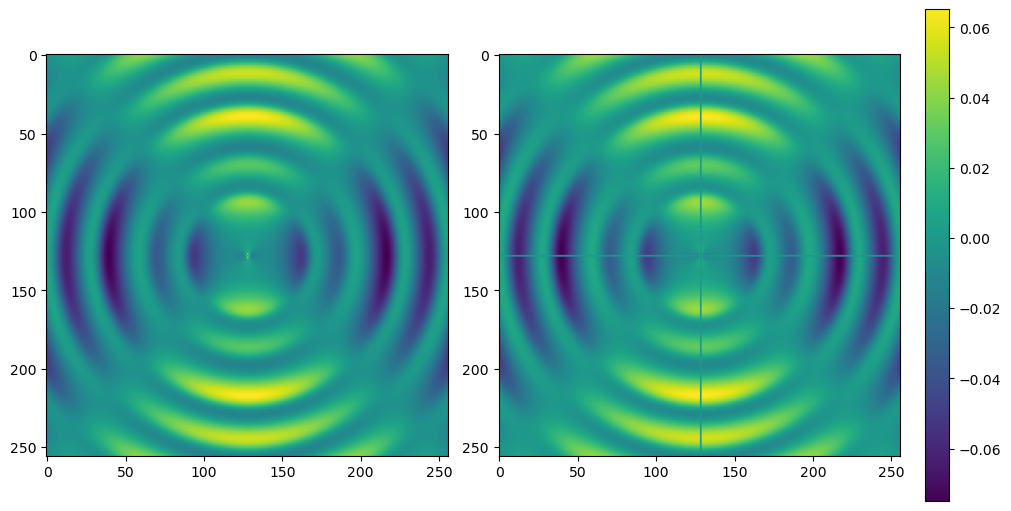

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), layout = 'constrained')
ax[0].imshow((np.fft.fftshift(ps_TT)-np.exp(ps_hat))/np.fft.fftshift(ps_TT))
c = ax[1].imshow((np.fft.fftshift(ps_TT)-np.fft.fftshift(ps_TT_mod))/np.fft.fftshift(ps_TT), cmap = 'viridis')
cbar = fig.colorbar(c)
plt.show()


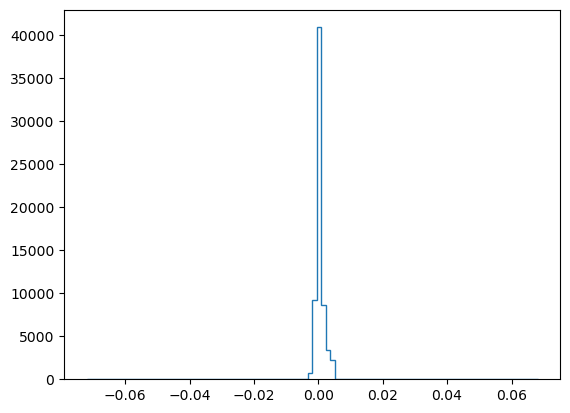

In [23]:
plt.hist(((ps_TT_mod-np.exp(si.Akima1DInterpolator(indices, up_diag)(wn_iso)))/ps_TT_mod).flatten(), bins=100, histtype='step', label='TT')
plt.show()

In [24]:
for i in range(10):
    si.Akima1DInterpolator(indices, up_diag)(wn_iso)

begin = time.time()
for i in range(1000):
    si.CubicSpline(indices, up_diag)(wn_iso)
end = time.time()
print('Spline and interpolation took {} seconds per iteration'.format((end-begin)/1000))

Spline and interpolation took 0.001293348789215088 seconds per iteration


In [25]:
DATA_FOLDER = '/mnt/home/dheurtel/ceph/01_data/'

DATA_DIR = 'CMB_PS_DIAG_H_ombh2'

In [26]:
os.listdir(DATA_FOLDER)

['CMB_PS_DIAG_H_ombh2', 'CATS_MHD_OrthBPROJ_DENSITY', 'CATS_MHD_BPROJ_DENSITY']

In [27]:
os.mkdir(os.path.join(DATA_FOLDER, DATA_DIR))

FileExistsError: [Errno 17] File exists: '/mnt/home/dheurtel/ceph/01_data/CMB_PS_DIAG_H_ombh2'

In [28]:
pars = camb.CAMBparams()

fixed_cosmo = True
zero_r = False

Npix = 256    # Number of pixels
res = 8       # Size of a pixel, in arcminutes

shape_patch, wcs_patch = patch_shape_and_wcs(Npix, res)
NUM_SAMPLES = 3000
start = 0

for i in range(start, start+NUM_SAMPLES):
    # From Planck 2018 I. paper Table 7
    H0 = np.random.uniform(47, 93)#np.random.uniform(50, 90)
    ombh2 = np.random.uniform(3.5e-3,60e-3) #np.random.uniform(7.5e-3,56.7e-3)
    omch2 = np.random.normal(0.12, 0.0012) if not fixed_cosmo else 0.12
    tau = np.random.normal(0.0544, 0.0073) if not fixed_cosmo else 0.0544
    logas = np.random.normal(3.044, 0.014) if not fixed_cosmo else 3.044
    As = np.exp(logas) / 1e10
    ns = np.random.normal(0.9649, 0.0042) if not fixed_cosmo else 0.9649

    # From Planck 2018 I. paper, see Sect. 5.3
    mnu = np.random.uniform(0.06, 0.1) if not fixed_cosmo else 0.8

    # Inspired from the upper limit of Planck 2018 I. paper
    logr = np.random.uniform(-3, -1.494850021680094)
    if not zero_r:
        r = 10**logr
    else:
        r = 0

    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=0, tau=tau)
    pars.InitPower.set_params(As=As, ns=ns, r=r)
    pars.set_for_lmax(4000, lens_potential_accuracy=0)
    pars.WantTensors = True

    results = camb.get_results(pars)
    cl_TT, cl_EE, cl_BB, cl_TE = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)['total'].T

    comp = np.zeros((3, 3, cl_TT.shape[-1]))
    comp[0,0] = cl_TT
    comp[1,1] = cl_EE
    comp[0,1] = cl_TE
    comp[1,0] = cl_TE
    comp[2,2] = cl_BB

    ps_maps = enmap.spec2flat(shape, wcs_patch, enmap.massage_spectrum(comp, shape), 1, mode='constant')

    diag =(np.fft.fftshift(np.log(ps_maps[0,0]).diagonal()))
    up_diag = diag[128:]
    theta = np.array([H0, ombh2])

    np.save( os.path.join(DATA_FOLDER, DATA_DIR, 'sample_{}.npy'.format(i)),up_diag)
    np.save( os.path.join(DATA_FOLDER, DATA_DIR, 'theta_{}.npy'.format(i)),theta)
    if i%10==0:
        print(i)

Size of the patch in degrees: 34.13
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
